In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC
from indicators.candle import OHLC

In [4]:
import time, datetime
from fyers_apiv3 import fyersModel
client_id = "ZHQ4IJL7TI-100"
with open("access_token", "r") as f:
    access_token = f.read()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

In [5]:
date_today = datetime.datetime.now().strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_today, date_100_p

('2024-11-23', '2024-08-15')

In [6]:
response = fyers.history(data={"symbol": "NSE:ZEEL-EQ",
                                "resolution": "1",
                                 "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_today,
                                "cont_flag": "1"
                                })

len(response['candles']), response

(25185,
 {'candles': [[1723779900, 134.75, 136.28, 134.5, 135.26, 218188],
   [1723779960, 135.26, 135.6, 135.26, 135.53, 40267],
   [1723780020, 135.53, 135.53, 135.15, 135.3, 44082],
   [1723780080, 135.3, 135.45, 135.14, 135.3, 29135],
   [1723780140, 135.45, 135.45, 135, 135.15, 69106],
   [1723780200, 135.13, 135.25, 134.88, 135.01, 47452],
   [1723780260, 135.01, 135.39, 135.01, 135.2, 51405],
   [1723780320, 135.2, 135.35, 135.05, 135.3, 106606],
   [1723780380, 135.34, 135.34, 135.05, 135.27, 24634],
   [1723780440, 135.27, 135.3, 135.1, 135.12, 27130],
   [1723780500, 135.12, 135.17, 134.9, 135.14, 32472],
   [1723780560, 135.14, 135.15, 134.92, 134.95, 9265],
   [1723780620, 134.8, 134.99, 134.76, 134.99, 22534],
   [1723780680, 134.99, 135, 134.8, 134.93, 15832],
   [1723780740, 134.93, 135.07, 134.86, 135.07, 9956],
   [1723780800, 135.07, 135.15, 134.94, 135.06, 33027],
   [1723780860, 134.95, 135.05, 134.85, 135.04, 27262],
   [1723780920, 135.04, 135.16, 134.92, 135.05, 

In [7]:
candles = np.array(response['candles'])
type(candles), candles

(numpy.ndarray,
 array([[1.72377990e+09, 1.34750000e+02, 1.36280000e+02, 1.34500000e+02,
         1.35260000e+02, 2.18188000e+05],
        [1.72377996e+09, 1.35260000e+02, 1.35600000e+02, 1.35260000e+02,
         1.35530000e+02, 4.02670000e+04],
        [1.72378002e+09, 1.35530000e+02, 1.35530000e+02, 1.35150000e+02,
         1.35300000e+02, 4.40820000e+04],
        ...,
        [1.73226942e+09, 1.16990000e+02, 1.16990000e+02, 1.16960000e+02,
         1.16990000e+02, 2.96590000e+04],
        [1.73226948e+09, 1.16990000e+02, 1.16990000e+02, 1.16910000e+02,
         1.16980000e+02, 6.26250000e+04],
        [1.73226954e+09, 1.16990000e+02, 1.17110000e+02, 1.16920000e+02,
         1.16950000e+02, 1.06265000e+05]]))

In [8]:
sync = SyncInd( 
    SMA(5),
    SMA(15),
    Alligator(13, 8, 5, 1, 1, 1),
    # RSI(),
    # ATR(),
    VolumeROC(),
                
)
                
for c in candles:
    sync.append(c)

In [9]:
sync.data()[50:52]

array([[1723782912.0, 135.69000244140625, 135.6999969482422,
        135.60000610351562, 135.64999389648438, 4156.0, 135.6, 135.68,
        135.65, 135.66, 135.64, -46.36727319654149],
       [1723782912.0, 135.64999389648438, 135.75, 135.60000610351562,
        135.63999938964844, 12642.0, 135.63, 135.68, 135.65, 135.66,
        135.64, 4.11793773678142]], dtype=object)

In [10]:
X, y = [], []

last_candles_count = 8
next_candles_count = 3

temp = []
for ind, i in enumerate(sync.data()):
    k = i.tolist()
    temp.append(k[1:5] + k[6:]) # deleting date and volume from the data
current_data = np.array(temp, dtype=np.float32)
# current_data = sync.data()[:, 1:]

for ind in range(50+(last_candles_count), current_data.shape[0]-50-(next_candles_count-1)):

    first_candle = current_data[ind-last_candles_count]
    temp = []
    for i in range(1, last_candles_count):
        temp.append(first_candle - current_data[(ind-last_candles_count)+i])

    X.append(temp)
    temp = []
    for j in range(next_candles_count):
        temp.append((first_candle - current_data[(ind + j)])[1])
    y.append(temp)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [11]:
X[0]

array([[ 4.00085449e-02, -5.00030518e-02,  0.00000000e+00,
         9.99450684e-03, -2.99987793e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.04852104e+01],
       [ 5.00030518e-02,  0.00000000e+00,  2.00012207e-01,
         1.79992676e-01,  0.00000000e+00,  1.99890137e-02,
         9.99450684e-03,  1.00097656e-02,  2.00042725e-02,
        -1.02685936e+02],
       [ 3.20007324e-01,  2.29995728e-01,  2.50000000e-01,
         2.09991455e-01,  2.99987793e-02,  4.99877930e-02,
         1.99890137e-02,  4.00085449e-02,  5.99975586e-02,
        -3.61309319e+01],
       [ 2.50000000e-01,  2.29995728e-01,  2.20001221e-01,
         1.89987183e-01,  7.00073242e-02,  5.99975586e-02,
         3.99932861e-02,  7.00073242e-02,  8.99963379e-02,
         4.15897522e+01],
       [ 2.29995728e-01,  2.09991455e-01,  2.00012207e-01,
         2.50000000e-01,  1.20010376e-01,  8.99963379e-02,
         4.99877930e-02,  8.00018311e-02,  1.10000610e-01,
         2.

In [12]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.05, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((23821, 7, 10), (23821, 3), (1254, 7, 10), (1254, 3))

In [13]:
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(next_candles_count))
# model.add(Reshape(y_train.shape[1:]))
model.compile(optimizer='adam', loss='mse')

In [14]:
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2)

Epoch 1/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2899 - val_loss: 0.1255
Epoch 2/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1903 - val_loss: 0.1131
Epoch 3/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1758 - val_loss: 0.1239
Epoch 4/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1593 - val_loss: 0.1193
Epoch 5/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1830 - val_loss: 0.1394
Epoch 6/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1855 - val_loss: 0.1182
Epoch 7/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1889 - val_loss: 0.1213
Epoch 8/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2165 - val_loss: 0.1174
Epoch 9/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1669 - val_loss: 0.1012
Epoch 10/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2159 - val_loss: 0.1104
Epoch 11/500
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1987 - val_loss: 0.1044
Epoch 12/500
298/298 ━━━━━━━━━

In [15]:
X.shape, y.shape

(TensorShape([25075, 7, 10]), TensorShape([25075, 3]))

In [16]:
y_pred = model.predict(X_test)
y_pred

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[ 0.25543284,  0.26273516,  0.2790739 ],
       [-0.50322855, -0.4767455 , -0.47003078],
       [ 0.44285798,  0.43536   ,  0.43318772],
       ...,
       [-0.6182534 , -0.5319954 , -0.4911173 ],
       [-0.10123962, -0.10370353, -0.11372347],
       [ 0.06830415,  0.05640081,  0.05318172]], dtype=float32)

In [17]:
for y_p, y_t in zip(y_pred, y_test):
    print("\n", (y_t[0]-y_p[0]), "\t", (y_t[1]-y_p[1]), "\t", (y_t[2]-y_p[2]))


 0.034560442 	 -0.17273882 	 -0.11908549

 -0.88677084 	 -1.3132478 	 -1.0299692

 0.037137747 	 0.124637544 	 0.276819

 0.016643047 	 -0.04624486 	 -0.06870216

 0.058481768 	 0.012861878 	 -0.06799053

 0.12600994 	 0.24556822 	 0.24294949

 -0.05071026 	 0.010438919 	 -0.015554786

 0.06477995 	 0.2494759 	 0.17126735

 -0.030698821 	 -0.07990624 	 -0.13806243

 0.07840209 	 0.08856358 	 0.07669923

 -0.17470461 	 -0.13977069 	 -0.14597571

 -0.11227077 	 0.10048318 	 0.0129932165

 -0.0123411715 	 -0.007911757 	 0.007924125

 0.06440185 	 0.054839715 	 0.053052023

 0.13260373 	 0.06461817 	 -0.00046813488

 0.100052595 	 0.1359365 	 0.17506376

 -0.048998296 	 -0.048649713 	 -0.07924673

 0.13330965 	 0.051721156 	 0.04316689

 0.13210668 	 0.025919728 	 -0.21702509

 0.124383025 	 0.12045055 	 0.018847182

 0.07070993 	 0.111930266 	 0.06514263

 0.0081516355 	 -0.01646325 	 0.009630635

 0.0705716 	 -0.018163562 	 0.06042701

 -0.16995066 	 -0.1641106 	 -0.14321363

 -0.033372

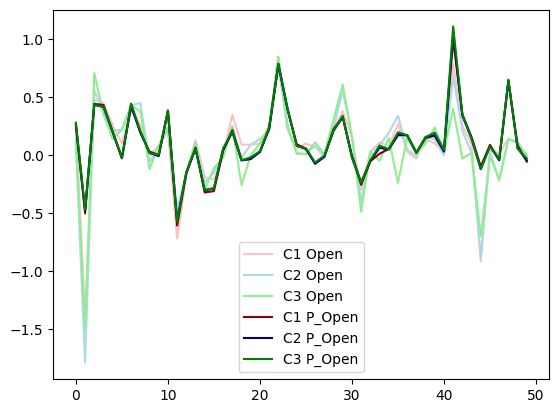

In [18]:
# Example for the first feature (e.g., Close price)
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

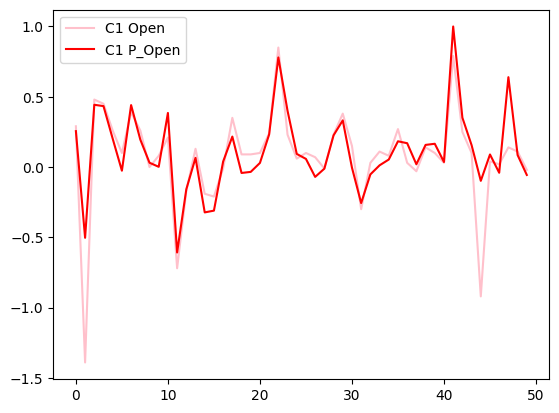

In [19]:
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
# plt.plot(y[0:5, 1], label='C2 Open', color="blue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="red")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

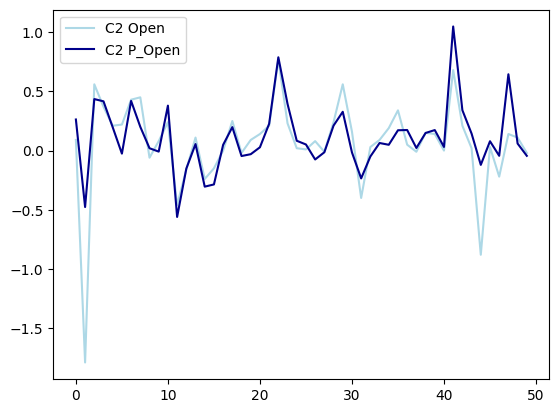

In [20]:
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

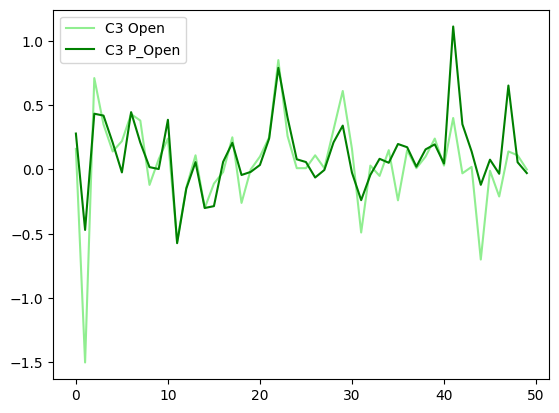

In [21]:
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

In [22]:
model.save("21NOV_1.keras")